# Homework 2 - Geospatial Analysis 

### EDS 296 

May 11, 2025 

Jordan Sibley 

[Link to access GitHub repository for this project](https://github.com/jordancsibley/eds296-geospatial-analysis)

## Accessing CMIP6 data 

1. Using the CMIP6 database hosted on Amazon Web Services, choose any two models you like: use both their historical simulations and future projections from one of the four major SSPs (ssp126, ssp245, ssp370, or ssp585). **Provide a brief description of the models and scenarios you chose to include.**

2. Access information from your chosen models and scenario, for any climate variable you like; however, note that three-dimensional data is generally larger and can be slower to load, so I recommend either choosing a two-dimensional data field or reading in only the surface level if you choose 3D information. Some common choices of variables to analyze, and their CMIP names, include:
- Surface air temperature (tas)
- Precipitation (pr)
- Sea surface temperature (tos)

### Set up 

In [32]:
# Import libraries 
import xarray as xr
import matplotlib.pyplot as plt
import intake
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime

In [33]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

### Query the Database

**CMIP6 Models**:
- CanESM5 
- MIROC6


I chose the Canadian Earth System Model and the Model for Interdisciplinary Research on Climate as they both show good performance in simulating North American air temperature, and additionally they both have data for historical and projected time. 


**Emission Scenario**: SSP 370

SSP3-7.0 is a medium to high-end climate scenario within the Shared Socioeconomic Pathways (SSPs) framework. I chose this projected emission scenario because it modeled after a future marked by regional competition and conflict, and a future where there are no additional climate policies are implemented ([Climatedata.ca](https://climatedata.ca/resource/understanding-shared-socio-economic-pathways-ssps/)). Based on the current US administration, this kind of future could be made possible, so I was interested in exploring a more extreme emission scenario such as this one. 

In [34]:
# Query catalog for my two models 
# Chose historical and projected activities: CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP']

# Select two models 
source_id = ['CanESM5', 'MIROC6']

# Select historical and ssp370 experimental configurations  
experiment_ids = ['historical', 'ssp370']

# Choose ensemble member id (starting condtions, internal variation) 
member_id = 'r1i1p1f1'

# Choose monthly time resolution
table_id = 'Amon'

# Select air temperature (tas) for the environmental varaible
variable_id = 'tas'

In [35]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/MIROC/MIROC6/histori...,NaN,20181212
1,ScenarioMIP,CCCma,CanESM5,ssp370,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
2,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
3,ScenarioMIP,MIROC,MIROC6,ssp370,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/MIROC/MIROC6/...,NaN,20190627


In [36]:
# Read in data and store as xarray object (CanESM5)
hist_canESM = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True}, consolidated=True)
ssp_canESM = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True}, consolidated=True)

# Read in data and store as xarray object (MIROC)
hist_miroc = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True}, consolidated=True)
ssp_miroc = xr.open_zarr(res.df['zstore'][3], storage_options={'anon': True}, consolidated=True)

In [37]:
# Concatenate historical and future projection data
# CanESM5 model 
canESM_tas = xr.concat([hist_canESM, ssp_canESM], dim="time")

# MIROC model
miroc_tas = xr.concat([hist_miroc, ssp_miroc], dim="time")

# Convert time to datetime64 format
canESM_tas['time'] = canESM_tas.time.astype('datetime64[ns]')
miroc_tas['time'] = miroc_tas.time.astype('datetime64[ns]')

# Sort by time for future filtering 
canESM_tas = canESM_tas.sortby('time')
miroc_tas = miroc_tas.sortby('time')

In [38]:
# Confirm data contains time ranges of interest 
print(canESM_tas.time.values[0])
print(canESM_tas.time.values[-1])

print(miroc_tas.time.values[0])
print(miroc_tas.time.values[-1])

1850-01-16T12:00:00.000000000
2100-12-16T12:00:00.000000000
1850-01-16T12:00:00.000000000
2100-12-16T12:00:00.000000000


## Choosing a study region 

3. Choose a region that you’re interested in to analyze, anywhere in the world. This should be a region that’s fairly large - think, the size of a large country or a sizable fraction of a continent. As you did for HW1, describe in markdown text some aspects of the climate of your region: **what are the interesting features there, and how might you expect that climate change would impact the area?**

The area of study I have choosen is a section of North America that includes Canada, United States, and Mexico. The climate of this large region varies with usual cooler temperatures on average in the North in Canda and warmer temperatures on averge in the South in Mexico. Due to rising temperatures due to climate change, all of this region is likely to expereince much higher average temperatures, potentially dangerous levels of air temperatures for areas in the US and Mexico, which is determinal to humans and animal life. 

In [39]:
# Define min/max bounds for region of North America 
north_america = [186.430435, 305.610123, 10.797073, 72.177181]

## Choosing two time periods to compare

4. Choose two separate time periods, each 30-50 years in length, and describe briefly why you chose these periods: then make some maps of the time average of your selected variable.
- Map the average over each time period separately
- Map the difference in the averages between the two time periods (note: make sure to label which time period you subtracted from which!)

For both your sets of maps, display some relevant political/geographic boundaries overlaid on the region: we saw some examples of how to do this using the Cartopy “feature” toolbox in the mapping tutorials.


- **Historical time period**: 1980-2010
- **Future time period**: 2030-2060

In [40]:
# Define time periods (historical and projected)
hist = [1980, 2010]
proj = [2030, 2060]

# Filter data of each model to historical and future time periods 
# CanESM 
canESM_tas_hist = canESM_tas.sel(time=slice(str(hist[0])+"-01-01", str(hist[1])+"-12-31"))
canESM_tas_proj = canESM_tas.sel(time=slice(str(proj[0])+"-01-01", str(proj[1])+"-12-31"))

# MIROC miroc_tas
miroc_tas_hist = miroc_tas.sel(time=slice(str(hist[0])+"-01-01", str(hist[1])+"-12-31"))
miroc_tas_proj = miroc_tas.sel(time=slice(str(proj[0])+"-01-01", str(proj[1])+"-12-31"))


# Calc averages over time periods and convert to celcius 
canESM_tas_histmn = canESM_tas_hist.mean(dim="time") - 273.15
canESM_tas_projmn = canESM_tas_proj.mean(dim="time") - 273.15

miroc_tas_histmn = miroc_tas_hist.mean(dim="time") - 273.15
miroc_tas_projmn = miroc_tas_proj.mean(dim="time") - 273.15

### Mapping average temperatures during each time period 

#### CanESM5

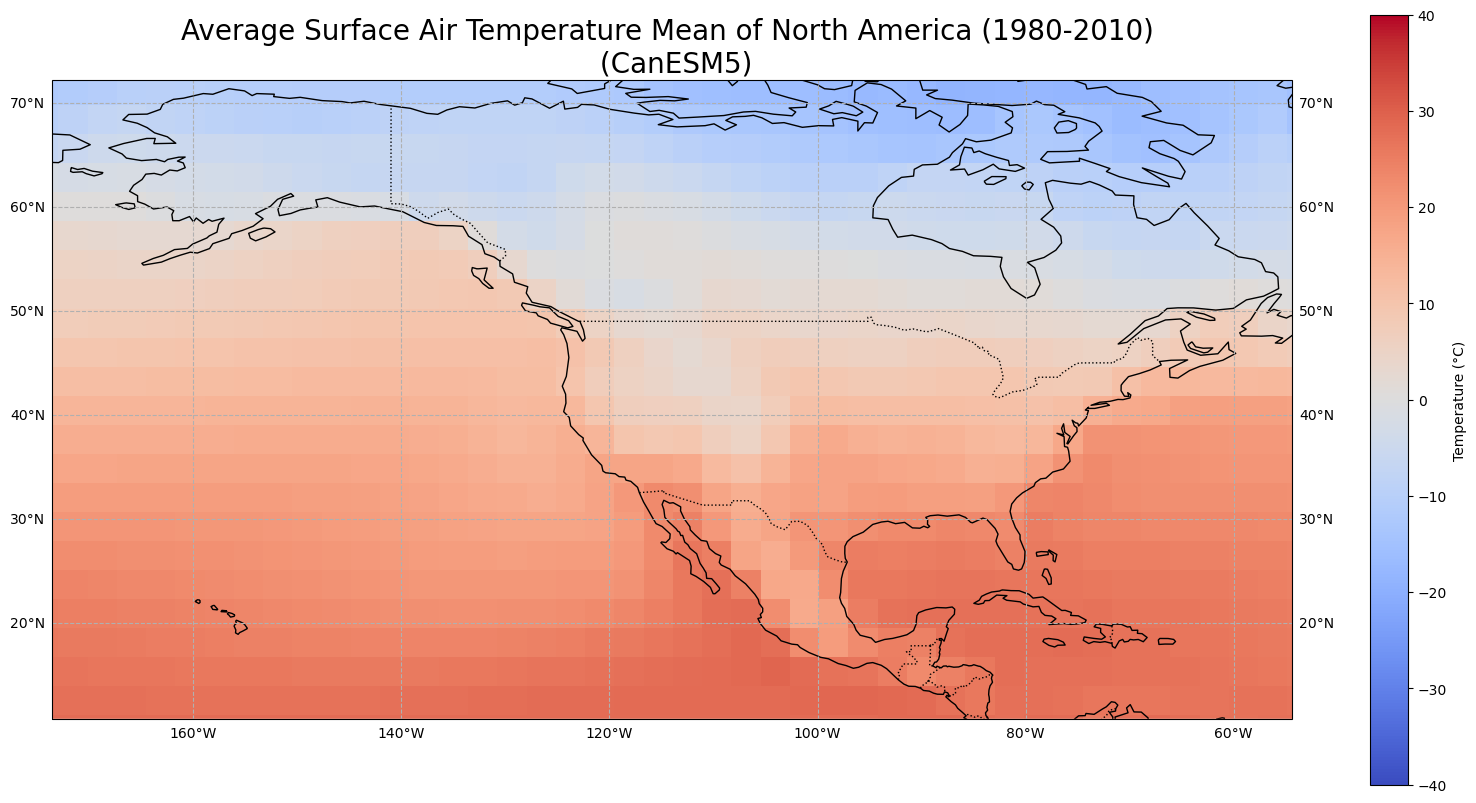

In [41]:
# ------- CanESM historical --------

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(canESM_tas_histmn.lon, 
                     canESM_tas_histmn.lat, 
                     canESM_tas_histmn["tas"],
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(north_america, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Average Surface Air Temperature Mean of North America (1980-2010) \n (CanESM5)", fontsize= 20)
plt.show()

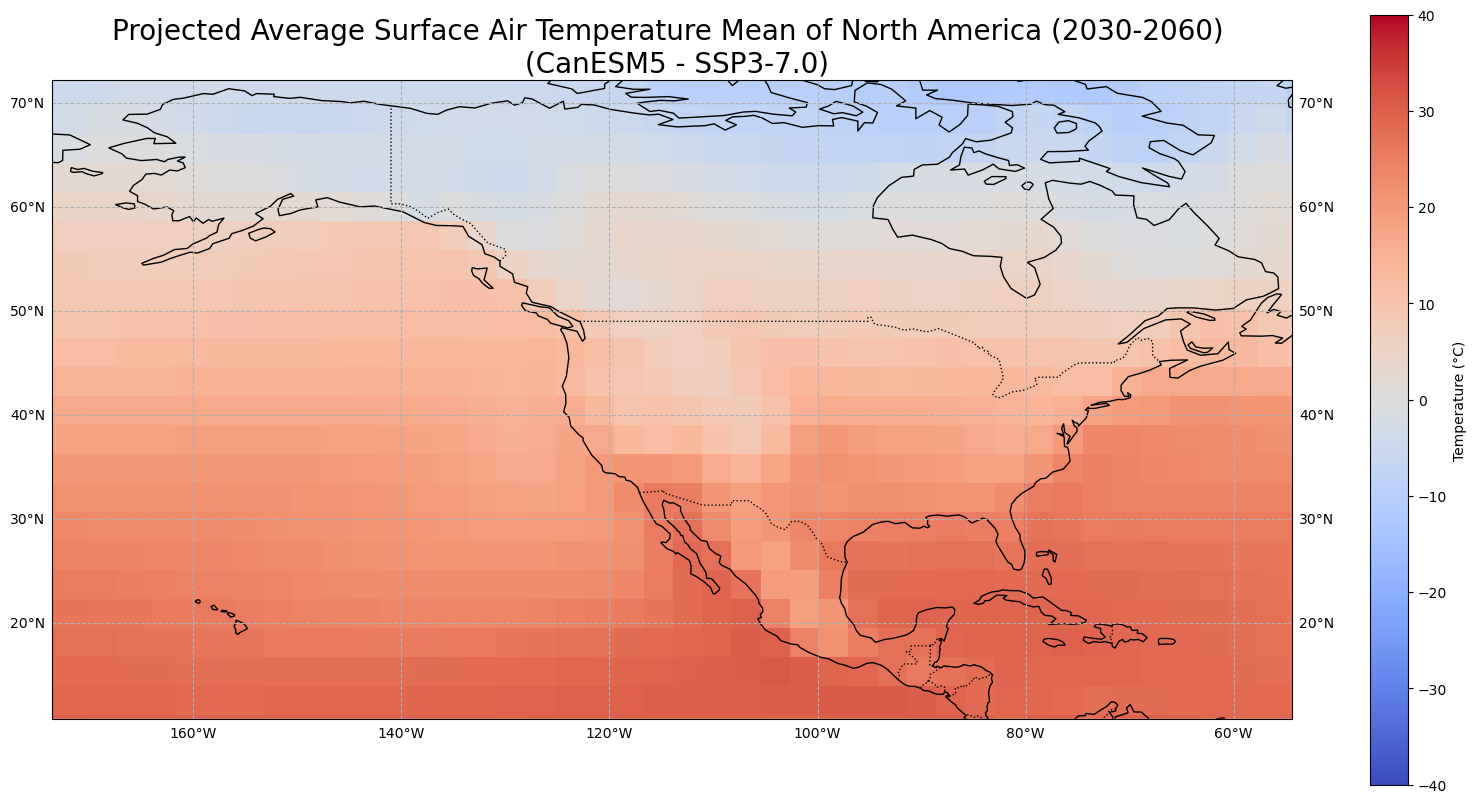

In [42]:
# ------- CanESM projected future --------

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(canESM_tas_projmn.lon, 
                     canESM_tas_projmn.lat, 
                     canESM_tas_projmn["tas"],
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(north_america, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Projected Average Surface Air Temperature Mean of North America (2030-2060) \n (CanESM5 - SSP3-7.0)", fontsize= 20)
plt.show()

#### MIROC6

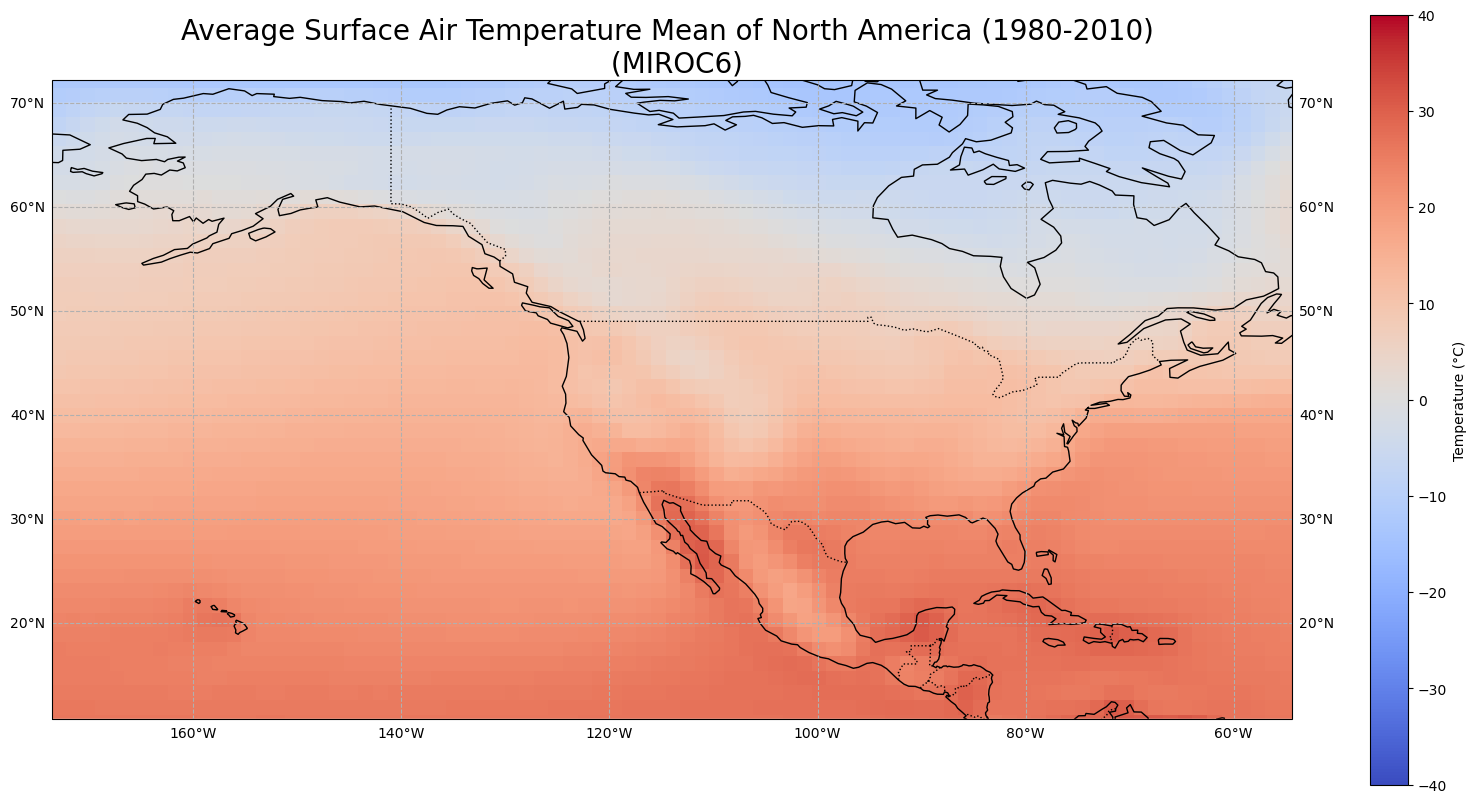

In [43]:
# ------- MIROC historical --------

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(miroc_tas_histmn.lon, 
                     miroc_tas_histmn.lat, 
                     miroc_tas_histmn["tas"],
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(north_america, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Average Surface Air Temperature Mean of North America (1980-2010) \n (MIROC6)", fontsize= 20)
plt.show()

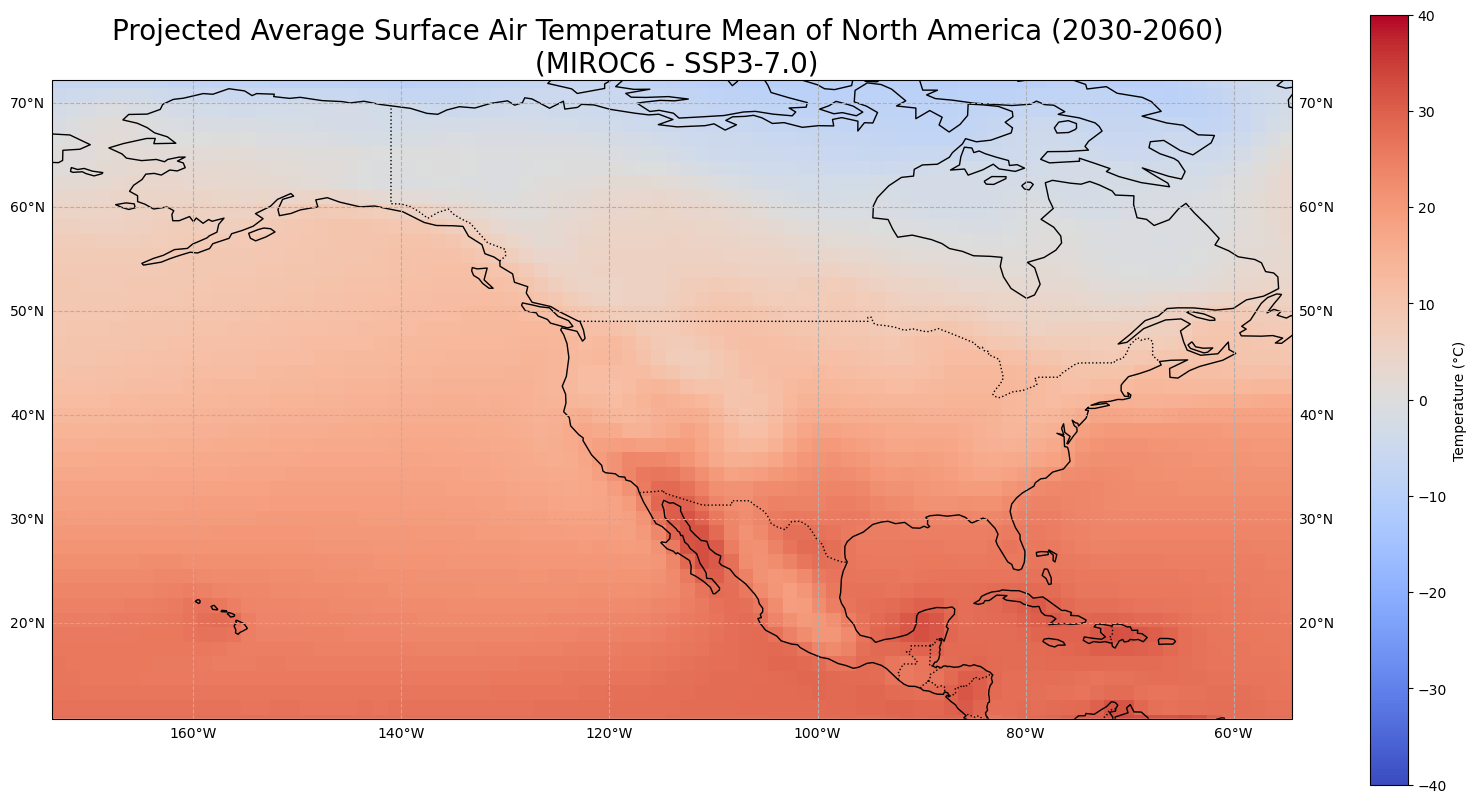

In [44]:
# ------- MIROC projected future --------

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(miroc_tas_projmn.lon, 
                     miroc_tas_projmn.lat, 
                     miroc_tas_projmn["tas"],
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(north_america, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Projected Average Surface Air Temperature Mean of North America (2030-2060) \n (MIROC6 - SSP3-7.0)", fontsize= 20)
plt.show()

### Map Differences in averages between historical and future time periods 

#### CanESM5

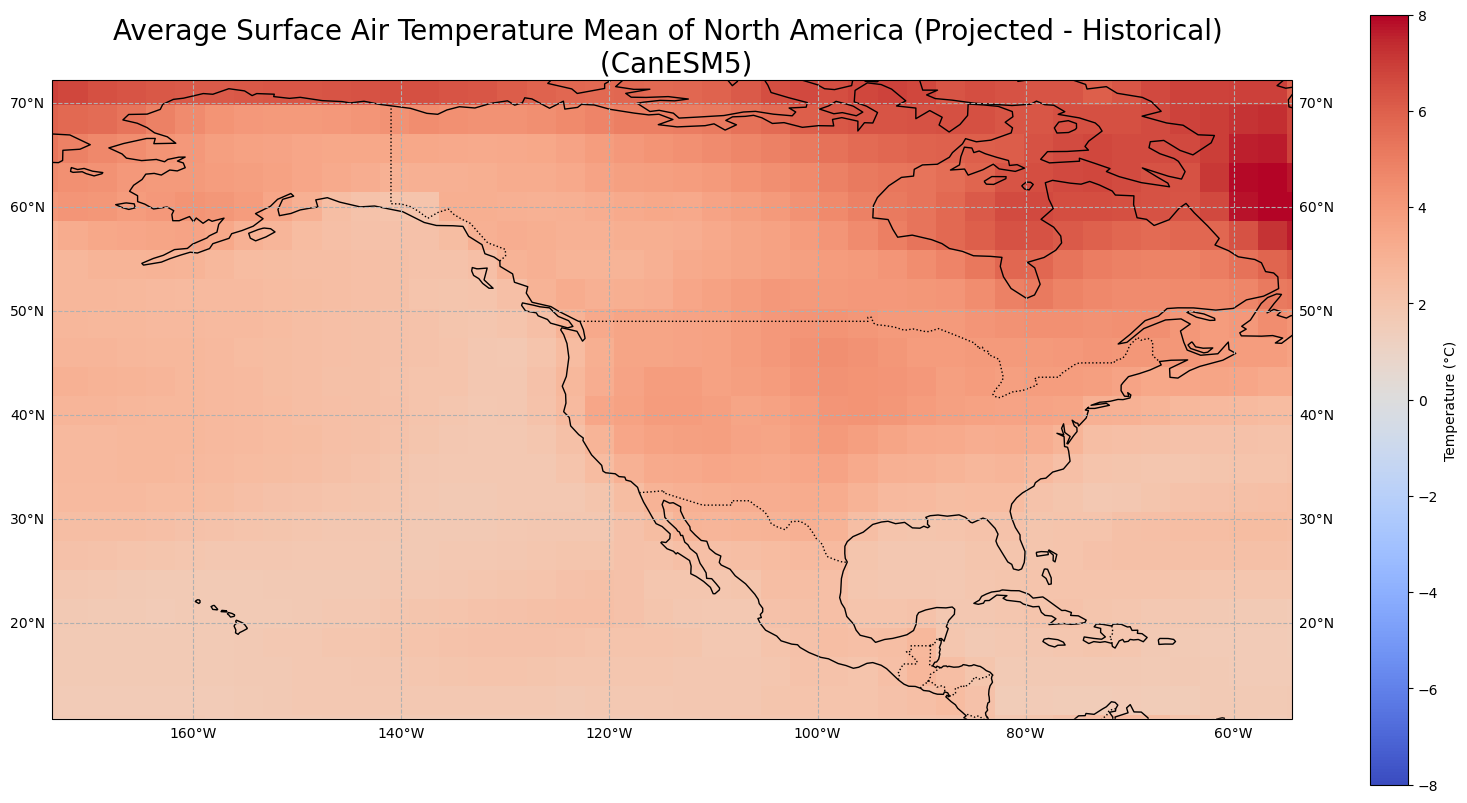

In [45]:
# ------- CanESM projected - historical --------

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(canESM_tas_projmn.lon, 
                     canESM_tas_projmn.lat, 
                     canESM_tas_projmn.tas - canESM_tas_histmn.tas,
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-8, 
                     vmax=8)

# Set spatial extent of plot
ax.set_extent(north_america, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Average Surface Air Temperature Mean of North America (Projected - Historical) \n (CanESM5)", fontsize= 20)
plt.show()

#### MIROC6

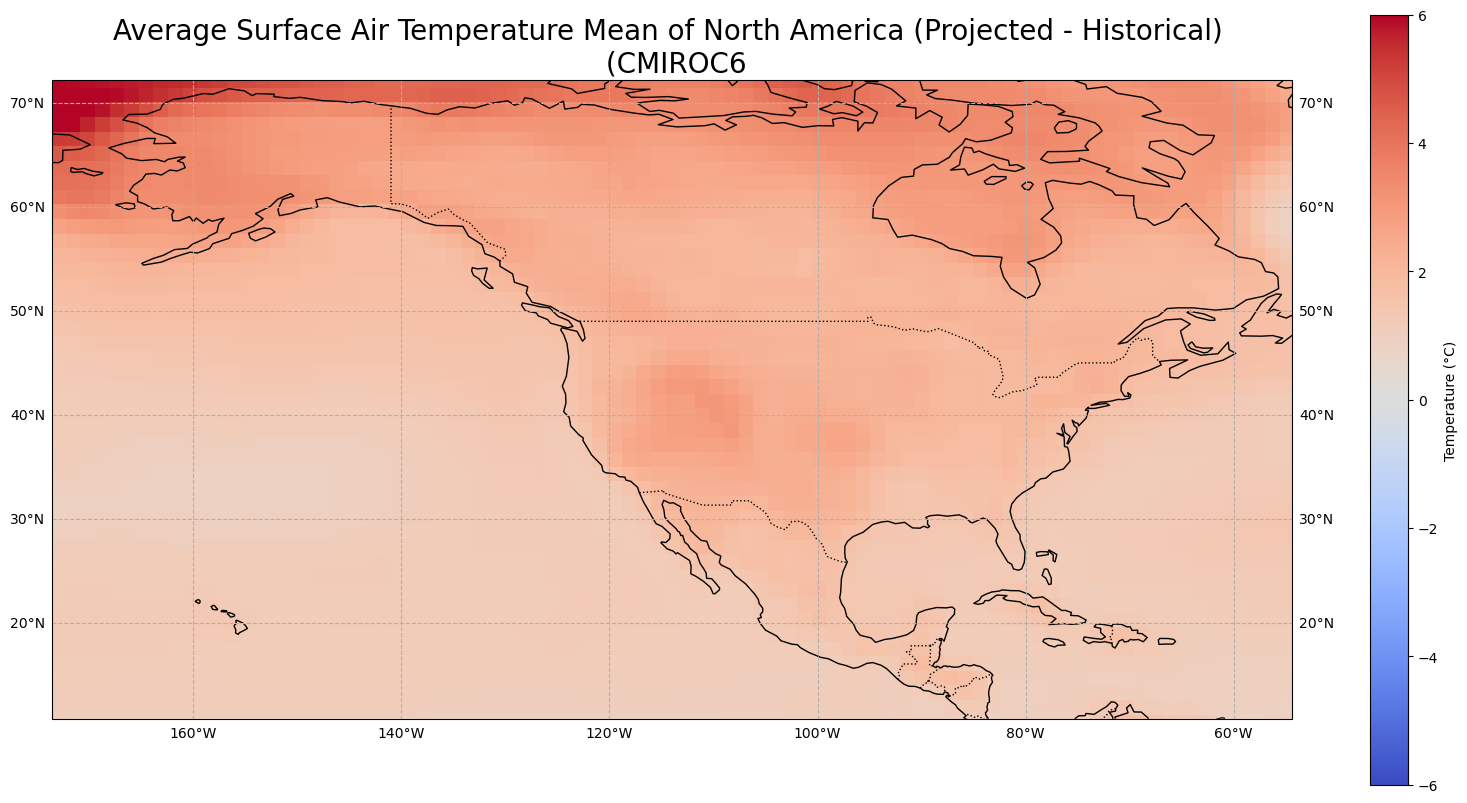

In [46]:
# ------- MIROC projected - historical --------

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(miroc_tas_projmn.lon, 
                     miroc_tas_projmn.lat, 
                     miroc_tas_projmn.tas - miroc_tas_histmn.tas,
                     transform=map, 
                     cmap="coolwarm", 
                     vmin=-6, 
                     vmax=6)

# Set spatial extent of plot
ax.set_extent(north_america, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Average Surface Air Temperature Mean of North America (Projected - Historical) \n (CMIROC6", fontsize= 20)
plt.show()

## Results 

5. Write 1-2 paragraphs in markdown text describing the results of your plot, and what you think they might mean for humans or ecosystems located in your study region. 

Both the CanESM5 and MIROC6 models showed similar results of the average temperatures during the historical period (1980-2010). They differ slightly in that the CanESM5 model shows slightly cooler temperatures up in northern Canada and the MIROC6 model shows slightly warmer conditions in the Gulf of California. For the projected data for the time period of 2030-2060 under the SSP 370, both models show elevated temperatures across Canada as compared to the historical time period, and high average temperatures in Mexico and Cuba. You are able to better see these difference between time periods in the last plots that plot the difference between the historical and projected temperature data. The CanESM5 model seems to predict a higher temperature change in places like North Eastern Canada while the MIROC6 model shows a slight lesser difference and highlights North Western Canada as having the highest temperature difference. These projected temperature increases could have serious implications for both humans and ecosystems in the North America. In Canada, rising temperatures may lead to permafrost thaw,which could release stored greenhouse gases. In Mexico and the Caribbean, higher temperatures could increase drought conditions, stress water resources, and affect agricultre. Warming may also shift species distributions and increase the frequency of extreme heat events, posing risks for vulnerable populations.